In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import keras
import json

Using TensorFlow backend.


### Load the preferences file

The preferences.json file contains all preference classes we designed. Right now they are 
 "Lit",
 "Active",
 "Relaxing",
 "Cultural"

In [2]:
with open("preferences.json","r") as fp:
    preferences = json.load(fp)
print preferences

[u'Lit', u'Active', u'Relaxing', u'Cultural']


### Load events dataset

In [25]:
with open("LabeledEvent.json","r") as fp:
    train = json.load(fp)
x = []
y = []
for event in train:
    text = ""
    if 'description' in event and event['description']:
        text += event['description']
    if 'title' in event and event['title']:
        text += event['title']
    if not text or not event['primaryPreference']:
        continue
    x.append(text)
    y.append(event['primaryPreference'])
print y
labelsFreq = Counter(y)

[u'Cultural', u'Lit', u'Cultural', u'Lit', u'Relaxing', u'Cultural', u'Cultural', u'Active', u'Lit', u'Relaxing', u'Active', u'Lit', u'Relaxing', u'Lit', u'Active', u'Lit', u'Lit', u'Lit', u'Relaxing', u'Lit', u'Active', u'Cultural', u'Lit', u'Active', u'Relaxing', u'Lit', u'Lit', u'Cultural', u'Active', u'Lit', u'Relaxing', u'Relaxing', u'Lit', u'Lit', u'Lit', u'Active', u'Relaxing', u'Relaxing', u'Cultural', u'Relaxing', u'Active', u'Active', u'Cultural', u'Lit', u'Lit', u'Active', u'Lit', u'Cultural', u'Active', u'Lit', u'Relaxing', u'Cultural', u'Active', u'Lit', u'Active', u'Active', u'Lit', u'Lit', u'Active', u'Cultural', u'Lit', u'Active', u'Lit', u'Lit', u'Active', u'Active', u'Relaxing', u'Active', u'Active', u'Relaxing', u'Active', u'Active', u'Relaxing', u'Active', u'Cultural', u'Cultural', u'Cultural', u'Cultural', u'Lit', u'Lit', u'Cultural', u'Relaxing', u'Active', u'Active', u'Active', u'Lit', u'Lit', u'Cultural', u'Active', u'Lit', u'Relaxing', u'Active', u'Cultural', u

### Encode event label

#### Train with events with single label

In [4]:
encoder = LabelEncoder()
encoder.fit(preferences)
encoded_y = encoder.transform(y)
print encoded_y
# convert integers to dummy variables (i.e. one hot encoded)
y = np_utils.to_categorical(encoded_y)

[1 2 1 2 3 1 1 0 2 3 0 2 3 2 0 2 2 2 3 2 0 1 2 0 3 2 2 1 0 2 3 3 2 2 2 0 3
 3 1 3 0 0 1 2 2 0 2 1 0 2 3 1 0 2 0 0 2 2 0 1 2 0 2 2 0 0 3 0 0 3 0 0 3 0
 1 1 1 1 2 2 1 3 0 0 0 2 2 1 0 2 3 0 1 3 1 2 3 1 0 2 3 0 3 0 2 3 0 0 2 0 1
 0 3 0 1 0 2 2 0 3 3 2 0 2 0 3 2 2 0 0 1 0 0 2 3 1 3 2 1 1 1 1 2 3 1 0 3 2
 3 3 3 0 2 0 1 3 0 1 2 0 1 3 0 1 3 2 0 0 0 0 2 0 0 0 2 0 0 3 0 1 1 3 1 2 2
 3 0 0 0 2 2 0 2 2 1 0 0 0 3 0 2 0 0 2 3 2 3 1 0 0 2 0 3 2 1 3 1 0 0 2 0 1
 0 1 2 0 0 3 0 0 2 2 3 2 1 0 3 0 2 1 2 2 3 2 3 0 3 3 0 0 2 1 3 1 2 1 0 0 2
 1 0 3 2 3 0 1 1 0 0 0 3 0 1 3 0 3 2 0]


In [24]:
encoder.classes_

array([u'Active', u'Cultural', u'Lit', u'Relaxing'], dtype='<U8')

#### Insights of Dataset

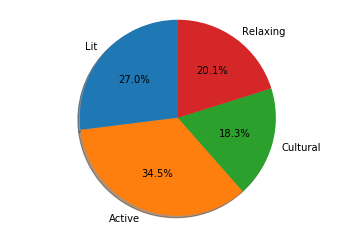

In [5]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = []
sizes = []
for preference in labelsFreq:
    labels.append(preference)
    sizes.append(labelsFreq[preference])

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

#### Train with event with multiple labels

In [12]:
# with open("train_fake_multiLabel.json","r") as fp:
#     train = json.load(fp)
# x = [event['text'] for event in train]
# y = [event['category'] for event in train]
# print y
# mlb = MultiLabelBinarizer()
# y = mlb.fit_transform(y)
# print y

#### Tokenize event text

In [6]:
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
x = pad_sequences(sequences, maxlen=180, padding="post")

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=9000)

### Build the model

In [8]:
filter_length = 300
max_words = 5000
num_classes = len(y[0])
maxlen = 180

In [17]:
keras.__version__

'2.2.4'

In [21]:
model = Sequential()
model.add(Embedding(max_words, 20, input_length=maxlen))
model.add(Dropout(0.1))
model.add(Conv1D(filter_length, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPool1D())
model.add(Dense(num_classes))
model.add(Activation('sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['categorical_accuracy'])
model.summary()

callbacks = [
    ReduceLROnPlateau(),
    EarlyStopping(patience=4),
    ModelCheckpoint(filepath='model_preference.h5', save_best_only=True)
]

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=callbacks)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 180, 20)           100000    
_________________________________________________________________
dropout_9 (Dropout)          (None, 180, 20)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 178, 300)          18300     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 300)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 1204      
_________________________________________________________________
activation_9 (Activation)    (None, 4)                 0         
Total params: 119,504
Trainable params: 119,504
Non-trainable params: 0
_________________________________________________________________
Trai

In [22]:
model_json = model.to_json()
with open("model_preference.json", "w") as json_file:
    json_file.write(model_json)
metrics = model.evaluate(x_test, y_test)
print("{}: {}".format(model.metrics_names[0], metrics[0]))
print("{}: {}".format(model.metrics_names[1], metrics[1]))

56/56 [==============================] - 0s 308us/step
loss: 0.546573093959
categorical_accuracy: 0.339285710028
